In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional


# Loading Dataset
df = pd.read_csv('AAWW.csv')

# Putting dates in correct format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', dayfirst=True)
df.sort_values('Date', inplace=True)

# Columns of dataset
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]

In [ ]:
data

,Open,High,Low,Close,Volume
0,30.000000,31.000000,30.000000,31.000000,130500
1,30.000000,31.000000,30.000000,31.000000,17700
2,30.000000,31.000000,30.000000,31.000000,3700
3,30.200001,31.500000,30.200001,31.000000,5400
4,30.250000,31.000000,30.000000,31.000000,6200
...,...,...,...,...,...
4297,100.379997,100.790001,100.260002,100.550003,167200
4298,100.309998,100.779999,100.309998,100.750000,142100
4299,100.800003,100.820000,100.400002,100.639999,113200
4300,100.690002,100.779999,100.500000,100.540001,187400


The new dataframe was created and the features such as Open, High, Low and close were extracted from the dataset. The distribution of the data is normal for all the features. We can see that the close vs volume plot does have few outliers.

In [ ]:
# Checking null values
print(data.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


No null values were found in the dataset.

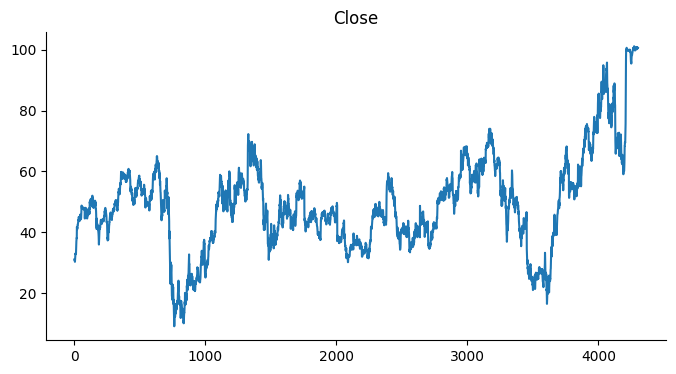

In [ ]:
# Exploring close price column

from matplotlib import pyplot as plt
data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

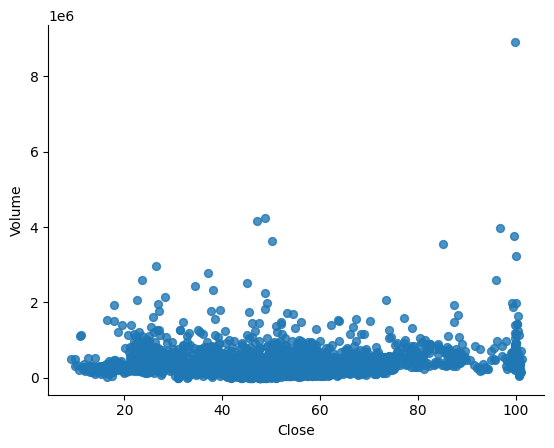

In [ ]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Close', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Checking for null values
if data.isnull().sum().any():
    print("Null values detected in the dataset!")
else:
    print("No null values found.")

# Normalizing dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Creating sequences
def create_sequences(data, target_column, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, target_column])
    return np.array(X), np.array(y)


n_steps_in = 30
n_steps_out = 3
target_feature = 'Close'
target_column_index = features.index(target_feature)

# Creating sequences
X, y = create_sequences(scaled_data, target_column=target_column_index, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

# Splitting the data into training set, validation set, and test sets
train_ratio = 0.7
val_ratio = 0.15

n_train = int(train_ratio * len(X))
n_val = int(val_ratio * len(X))

X_train, X_val, X_test = X[:n_train], X[n_train:n_train + n_val], X[n_train + n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train + n_val], y[n_train + n_val:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Building and training the model
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, n_steps_out, units=50, dropout_rate=0.2, epochs=50):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation='relu'))
    elif model_type == 'GRU':
        model.add(GRU(units, activation='relu'))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='relu'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(units, activation='relu')))

    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, callbacks=[early_stop], verbose=1)

    return model

rnn_model = build_and_train_model('RNN', X_train, y_train, X_val, y_val, n_steps_out)
gru_model = build_and_train_model('GRU', X_train, y_train, X_val, y_val, n_steps_out)
lstm_model = build_and_train_model('LSTM', X_train, y_train, X_val, y_val, n_steps_out)
bi_lstm_model = build_and_train_model('Bi-LSTM', X_train, y_train, X_val, y_val, n_steps_out)


No null values found.
X_train shape: (2989, 30, 5)
y_train shape: (2989, 3)
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0592 - val_loss: 0.0014
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 9.6207e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 8.5411e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 7.9297e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 7.6110e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0032 - val_loss: 8.4649e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 6.4972e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 5.9203e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 5.8518e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 8.2540e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

In [ ]:
def make_predictions(model, X_test, scaler, num_features, target_column_index):

    # Getting predictions
    predictions = model.predict(X_test)

    # Expanding the predictions to match the scaled feature dimensions
    expanded_predictions = np.zeros((predictions.shape[0], num_features))

    # Putting predictions into the target column index
    expanded_predictions[:, target_column_index] = predictions[:, -1]

    # Inverse transforming the data using scaler
    predictions_rescaled = scaler.inverse_transform(expanded_predictions)

    # Returning predictions
    return predictions_rescaled[:, target_column_index]


# Checking to see if the number of features is correct
num_features = len(features)
target_column_index = features.index('Close')  # Index of the target column

# Making predictions from each model
rnn_predictions = make_predictions(rnn_model, X_test, scaler, num_features, target_column_index)
gru_predictions = make_predictions(gru_model, X_test, scaler, num_features, target_column_index)
lstm_predictions = make_predictions(lstm_model, X_test, scaler, num_features, target_column_index)
bi_lstm_predictions = make_predictions(bi_lstm_model, X_test, scaler, num_features, target_column_index)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
print(f"y_test shape: {y_test.shape}")


y_test shape: (641, 3)


In [ ]:
def rescale_y_test(y_test, scaler, num_features, target_column_index):

    expanded_y_test = np.zeros((y_test.shape[0] * y_test.shape[1], num_features))

    expanded_y_test[:, target_column_index] = y_test.flatten()

    # Inverse transforming the dataset using scaler
    rescaled_y_test = scaler.inverse_transform(expanded_y_test)

    # Returning the target column
    return rescaled_y_test[:, target_column_index].reshape(y_test.shape)


y_test_rescaled = rescale_y_test(y_test, scaler, num_features, target_column_index)
print(f"Rescaled y_test shape: {y_test_rescaled.shape}")


Rescaled y_test shape: (641, 3)


In [ ]:

target_column_index = features.index('Close')

# Rescaling the test data
y_test_rescaled = rescale_y_test(y_test, scaler, num_features, target_column_index)

# Extracting only the Closing price column
y_test_close = y_test_rescaled[:, -1]
print(f"y_test_close shape: {y_test_close.shape}")


y_test_close shape: (641,)


RNN - MSE: 12.8542, MAE: 2.5922, R²: 0.9518
GRU - MSE: 12.9890, MAE: 2.6167, R²: 0.9513
LSTM - MSE: 19.3611, MAE: 3.2114, R²: 0.9273
Bi-LSTM - MSE: 51.1581, MAE: 5.3079, R²: 0.8080


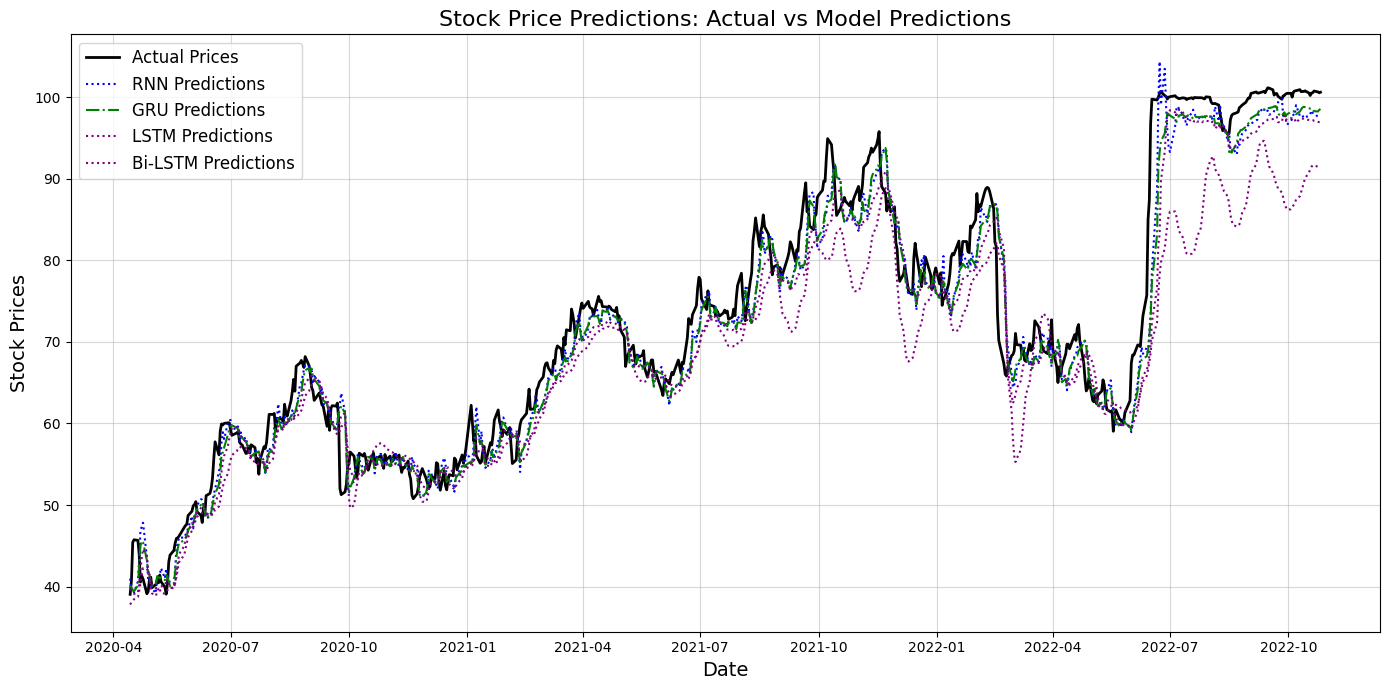

In [ ]:

min_len = min(len(y_test_close), len(rnn_predictions), len(gru_predictions), len(lstm_predictions), len(bi_lstm_predictions))
y_test_close = y_test_close[:min_len]
rnn_predictions = rnn_predictions[:min_len]
gru_predictions = gru_predictions[:min_len]
lstm_predictions = lstm_predictions[:min_len]
bi_lstm_predictions = bi_lstm_predictions[:min_len]

# Aligning all the dates
aligned_dates = df['Date'][n_train + n_val:][:min_len]

# Evaluating model metrics
def evaluate_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, mae, r2

rnn_mse, rnn_mae, rnn_r2 = evaluate_model(y_test_close, rnn_predictions)
gru_mse, gru_mae, gru_r2 = evaluate_model(y_test_close, gru_predictions)
lstm_mse, lstm_mae, lstm_r2 = evaluate_model(y_test_close, lstm_predictions)
bi_lstm_mse, bi_lstm_mae, bi_lstm_r2 = evaluate_model(y_test_close, bi_lstm_predictions)




print(f"RNN - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, R²: {rnn_r2:.4f}")
print(f"GRU - MSE: {gru_mse:.4f}, MAE: {gru_mae:.4f}, R²: {gru_r2:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, R²: {lstm_r2:.4f}")
print(f"Bi-LSTM - MSE: {bi_lstm_mse:.4f}, MAE: {bi_lstm_mae:.4f}, R²: {bi_lstm_r2:.4f}")


# Actual vs predicted plot
plt.figure(figsize=(14, 7))
plt.plot(aligned_dates, y_test_close, label='Actual Prices', color='black', linewidth=2)
plt.plot(aligned_dates, rnn_predictions, label='RNN Predictions', linestyle='dotted', color='blue')
plt.plot(aligned_dates, gru_predictions, label='GRU Predictions', linestyle='dashdot', color='green')
plt.plot(aligned_dates, lstm_predictions, label='LSTM Predictions', linestyle='dotted', color='purple')
plt.plot(aligned_dates, bi_lstm_predictions, label='Bi-LSTM Predictions', linestyle='dotted', color='purple')
plt.title('Stock Price Predictions: Actual vs Model Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Prices', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


We can try modelling for the closing price at M = 1 as well and then compare it with the M = 3 results.

**M = 1**

In [ ]:
def create_sequences(data, target_column, n_steps_in, n_steps_out):

    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])  # All features
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, target_column])  # Only target column
    return np.array(X), np.array(y)

In [ ]:
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, n_steps_out, units=50, dropout_rate=0.2, epochs=50):

    model = Sequential()

    # Defining the input layer
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Adding the RNN layers
    if model_type == 'RNN':
        model.add(SimpleRNN(units, activation='relu'))
    elif model_type == 'GRU':
        model.add(GRU(units, activation='relu'))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='relu'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(units, activation='relu')))

    # Dropout implemented for regularization
    model.add(Dropout(dropout_rate))

    # Output layer added
    model.add(Dense(n_steps_out))

    # The model is compiled
    model.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training the model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    return model


In [ ]:

n_steps_in = 30
n_steps_out_m1 = 1  # M = 1

# Creating the sequences
X_m1, y_m1 = create_sequences(scaled_data, target_column=target_column_index, n_steps_in=n_steps_in, n_steps_out=n_steps_out_m1)

# Dataset splitting
n_train_m1 = int(train_ratio * len(X_m1))
n_val_m1 = int(val_ratio * len(X_m1))
X_train_m1, X_val_m1, X_test_m1 = X_m1[:n_train_m1], X_m1[n_train_m1:n_train_m1 + n_val_m1], X_m1[n_train_m1 + n_val_m1:]
y_train_m1, y_val_m1, y_test_m1 = y_m1[:n_train_m1], y_m1[n_train_m1:n_train_m1 + n_val_m1], y_m1[n_train_m1 + n_val_m1:]

# Training all the models for M=1
rnn_model_m1 = build_and_train_model('RNN', X_train_m1, y_train_m1, X_val_m1, y_val_m1, n_steps_out_m1)
gru_model_m1 = build_and_train_model('GRU', X_train_m1, y_train_m1, X_val_m1, y_val_m1, n_steps_out_m1)
lstm_model_m1 = build_and_train_model('LSTM', X_train_m1, y_train_m1, X_val_m1, y_val_m1, n_steps_out_m1)
bi_lstm_model_m1 = build_and_train_model('Bi-LSTM M1', X_train_m1, y_train_m1, X_val_m1, y_val_m1, n_steps_out_m1)




Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0274 - val_loss: 0.0011
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 4.0206e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 8.5526e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 4.1418e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 5.7785e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 6.0262e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 3.3251e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 3.4009e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 3.8942e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 5.3077e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 3.6546e-04
Epoch 12/50
94/94 ━━━━━━━━━━━━━━

In [ ]:
def make_predictions_m1(model, X_test, scaler, num_features, target_column_index):

    predictions = model.predict(X_test)

    if predictions.ndim > 2:
        predictions = predictions[:, -1, :]

    expanded_predictions = np.zeros((predictions.shape[0], num_features))

    expanded_predictions[:, target_column_index] = predictions.flatten()

    predictions_rescaled = scaler.inverse_transform(expanded_predictions)

    return predictions_rescaled[:, target_column_index]


In [ ]:
rnn_predictions_m1 = make_predictions_m1(rnn_model_m1, X_test_m1, scaler, num_features, target_column_index)
gru_predictions_m1 = make_predictions_m1(gru_model_m1, X_test_m1, scaler, num_features, target_column_index)
lstm_predictions_m1 = make_predictions_m1(lstm_model_m1, X_test_m1, scaler, num_features, target_column_index)
bi_lstm_predictions_m1 = make_predictions_m1(bi_lstm_model_m1, X_test_m1, scaler, num_features, target_column_index)


y_test_rescaled_m1 = rescale_y_test(y_test_m1, scaler, num_features, target_column_index)
y_test_close_m1 = y_test_rescaled_m1.flatten()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


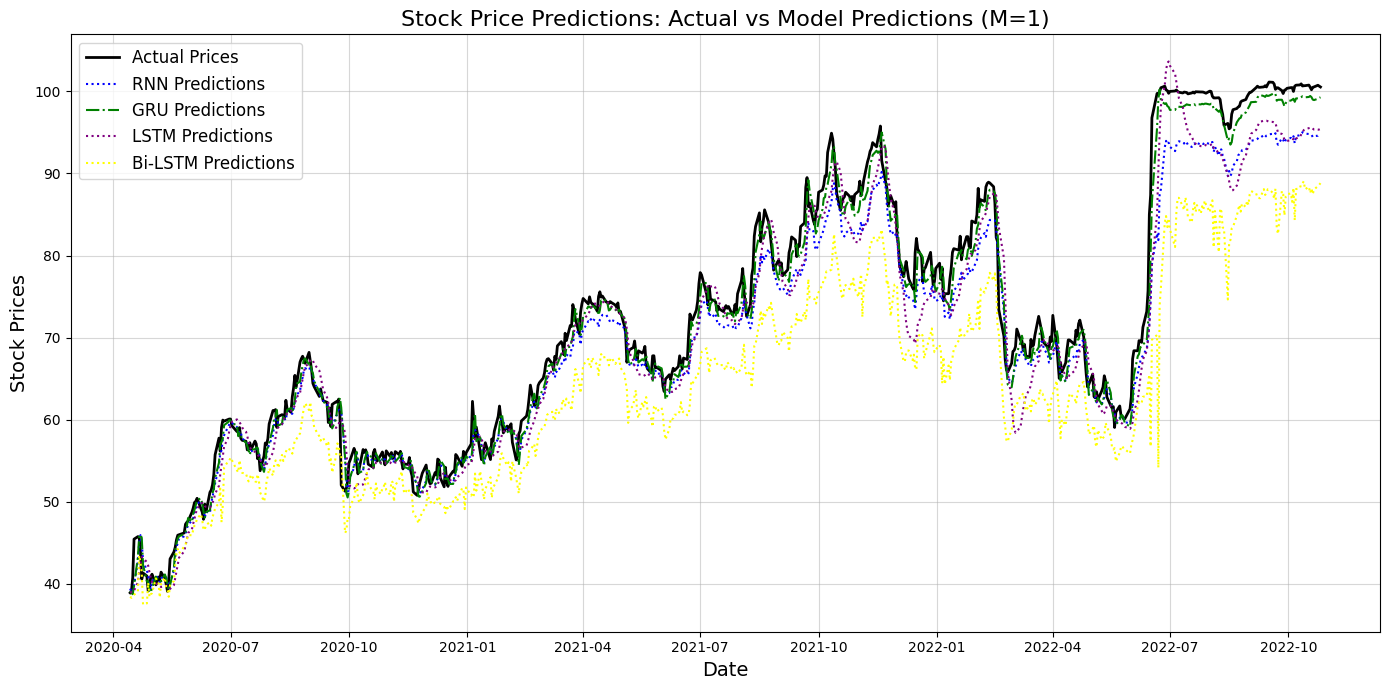

In [ ]:

min_len_m1 = min(len(aligned_dates), len(y_test_close_m1), len(rnn_predictions_m1), len(gru_predictions_m1), len(lstm_predictions_m1))


aligned_dates_m1 = aligned_dates[:min_len_m1]
y_test_close_m1 = y_test_close_m1[:min_len_m1]
rnn_predictions_m1 = rnn_predictions_m1[:min_len_m1]
gru_predictions_m1 = gru_predictions_m1[:min_len_m1]
lstm_predictions_m1 = lstm_predictions_m1[:min_len_m1]
bi_lstm_predictions_m1 = bi_lstm_predictions_m1[:min_len_m1]

plt.figure(figsize=(14, 7))
plt.plot(aligned_dates_m1, y_test_close_m1, label='Actual Prices', color='black', linewidth=2)
plt.plot(aligned_dates_m1, rnn_predictions_m1, label='RNN Predictions', linestyle='dotted', color='blue')
plt.plot(aligned_dates_m1, gru_predictions_m1, label='GRU Predictions', linestyle='dashdot', color='green')
plt.plot(aligned_dates_m1, lstm_predictions_m1, label='LSTM Predictions', linestyle='dotted', color='purple')
plt.plot(aligned_dates_m1, bi_lstm_predictions_m1, label='Bi-LSTM Predictions', linestyle='dotted', color='yellow')
plt.title('Stock Price Predictions: Actual vs Model Predictions (M=1)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Prices', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


Comparision

In [ ]:
# Evaluation For M=1
rnn_mse_m1, rnn_mae_m1, rnn_r2_m1 = evaluate_model(y_test_close_m1, rnn_predictions_m1)
gru_mse_m1, gru_mae_m1, gru_r2_m1 = evaluate_model(y_test_close_m1, gru_predictions_m1)
lstm_mse_m1, lstm_mae_m1, lstm_r2_m1 = evaluate_model(y_test_close_m1, lstm_predictions_m1)
bi_lstm_mse_m1, bi_lstm_mae_m1, bi_lstm_r2_m1 = evaluate_model(y_test_close_m1, bi_lstm_predictions_m1)

# Evaluating for M=3
#rnn_mse_m3, rnn_mae_m3, rnn_r2_m3 = evaluate_model(y_test_close_m3, rnn_predictions_m3)
#gru_mse_m3, gru_mae_m3, gru_r2_m3 = evaluate_model(y_test_close_m3, gru_predictions_m3)
#lstm_mse_m3, lstm_mae_m3, lstm_r2_m3 = evaluate_model(y_test_close_m3, lstm_predictions_m3)


In [ ]:

print("Performance Comparison (M = 1 vs M = 3):")
models = ['RNN', 'GRU', 'LSTM', 'Bi-LSTM']
results_m1 = [rnn_mse_m1, rnn_mae_m1, rnn_r2_m1, gru_mse_m1, gru_mae_m1, gru_r2_m1, lstm_mse_m1, lstm_mae_m1, lstm_r2_m1, bi_lstm_mse_m1, bi_lstm_mae_m1, bi_lstm_r2_m1]
results_m3 = [rnn_mse, rnn_mae, rnn_r2, gru_mse, gru_mae, gru_r2, lstm_mse, lstm_mae, lstm_r2, bi_lstm_mse, bi_lstm_mae, bi_lstm_r2]

for i, model in enumerate(models):
    print(f"{model} (M=1): MSE={results_m1[i*3]:.4f}, MAE={results_m1[i*3+1]:.4f}, R²={results_m1[i*3+2]:.4f}")
    print(f"{model} (M=3): MSE={results_m3[i*3]:.4f}, MAE={results_m3[i*3+1]:.4f}, R²={results_m3[i*3+2]:.4f}")


Performance Comparison (M = 1 vs M = 3):
RNN (M=1): MSE=14.4499, MAE=2.8877, R²=0.9459
RNN (M=3): MSE=12.8542, MAE=2.5922, R²=0.9518
GRU (M=1): MSE=3.8167, MAE=1.5121, R²=0.9857
GRU (M=3): MSE=12.9890, MAE=2.6167, R²=0.9513
LSTM (M=1): MSE=15.5514, MAE=3.0516, R²=0.9417
LSTM (M=3): MSE=19.3611, MAE=3.2114, R²=0.9273
Bi-LSTM (M=1): MSE=84.7298, MAE=8.0102, R²=0.6826
Bi-LSTM (M=3): MSE=51.1581, MAE=5.3079, R²=0.8080


Find the best model

In [ ]:

results_m1 = {
    "RNN": {"MSE": rnn_mse_m1, "MAE": rnn_mae_m1, "R²": rnn_r2_m1},
    "GRU": {"MSE": gru_mse_m1, "MAE": gru_mae_m1, "R²": gru_r2_m1},
    "LSTM": {"MSE": lstm_mse_m1, "MAE": lstm_mae_m1, "R²": lstm_r2_m1},
    "Bi-LSTM": {"MSE": bi_lstm_mse_m1, "MAE": bi_lstm_mae_m1, "R²": bi_lstm_r2_m1},
}


results_m3 = {
    "RNN": {"MSE": rnn_mse, "MAE": rnn_mae, "R²": rnn_r2},
    "GRU": {"MSE": gru_mse, "MAE": gru_mae, "R²": gru_r2},
    "LSTM": {"MSE": lstm_mse, "MAE": lstm_mae, "R²": lstm_r2},
    "Bi-LSTM": {"MSE": bi_lstm_mse, "MAE": bi_lstm_mae, "R²": bi_lstm_r2},
}

# Selecting the best models
def select_best_model(results):
    best_model = min(results, key=lambda model: results[model]["MSE"])
    return best_model, results[best_model]

best_model_m1, best_metrics_m1 = select_best_model(results_m1)
best_model_m3, best_metrics_m3 = select_best_model(results_m3)

print(f"Best Model for M=1: {best_model_m1} with MSE={best_metrics_m1['MSE']:.4f}, R²={best_metrics_m1['R²']:.4f}")
print(f"Best Model for M=3: {best_model_m3} with MSE={best_metrics_m3['MSE']:.4f}, R²={best_metrics_m3['R²']:.4f}")


Best Model for M=1: GRU with MSE=3.8167, R²=0.9857
Best Model for M=3: RNN with MSE=12.8542, R²=0.9518


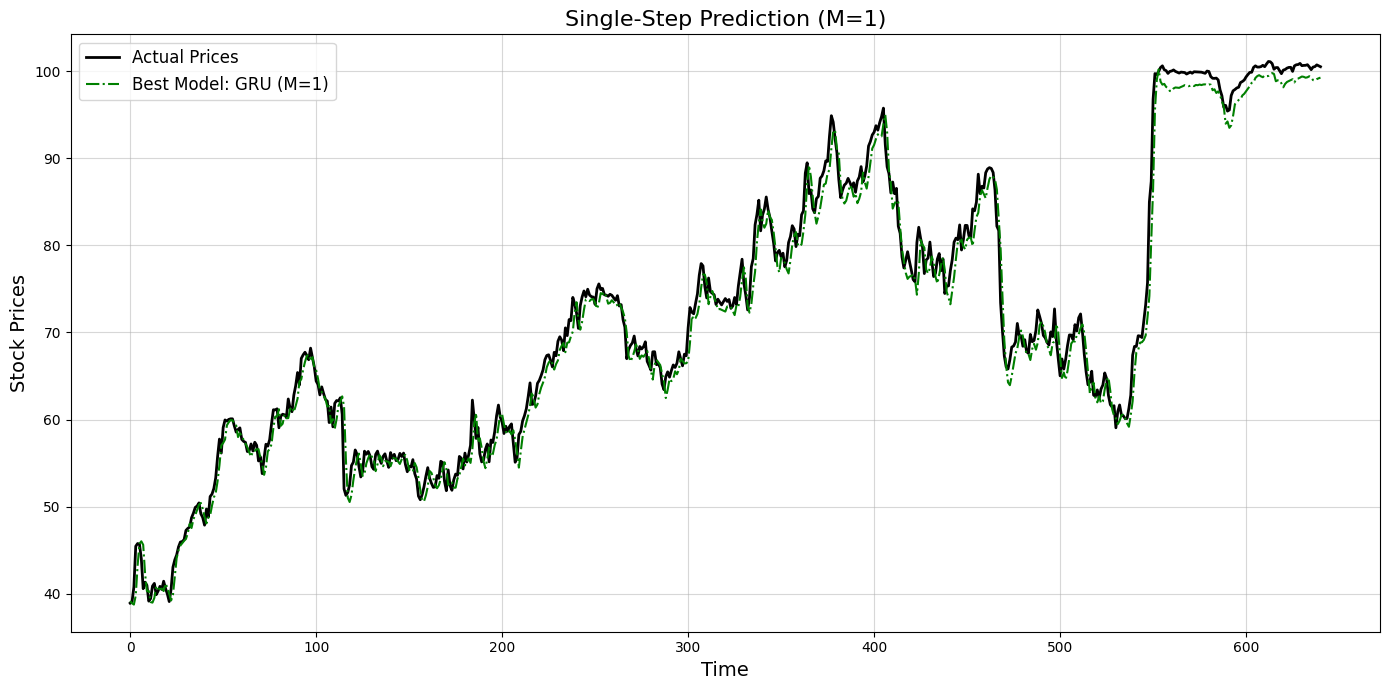

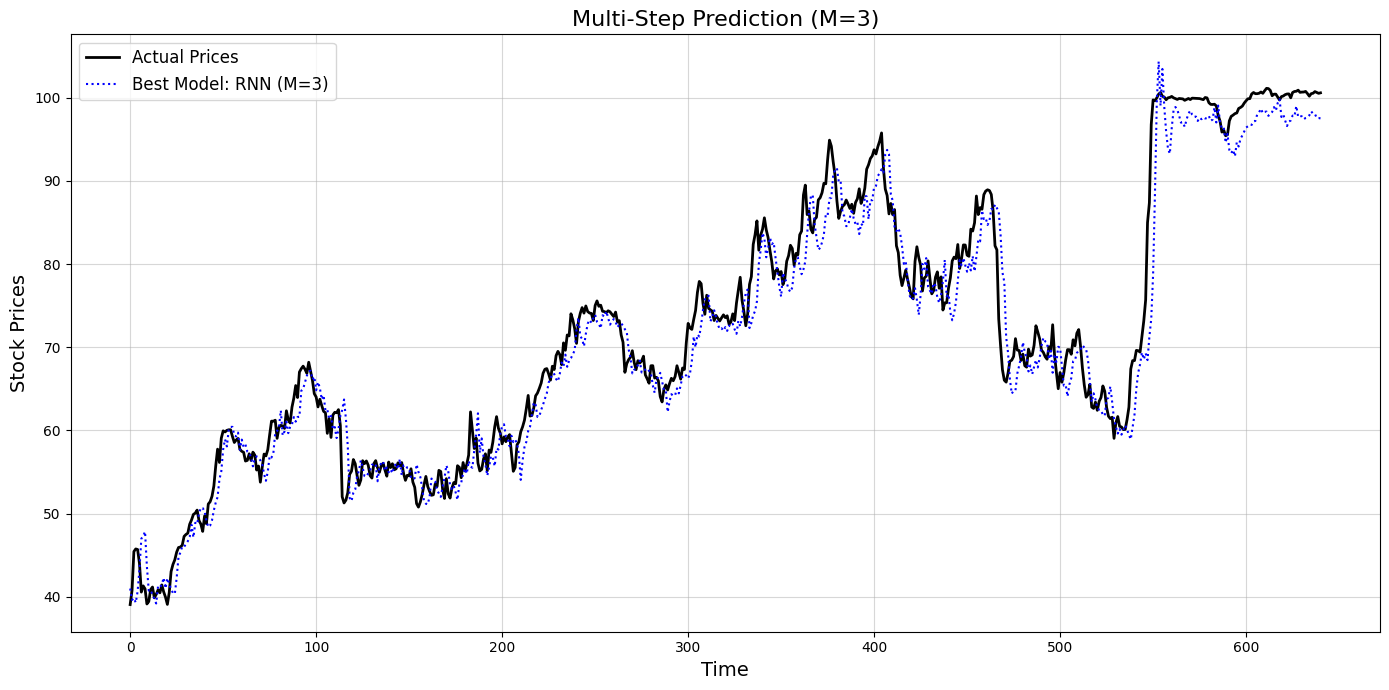

In [ ]:
# Predictions for M=1
plt.figure(figsize=(14, 7))
plt.plot(y_test_close_m1, label='Actual Prices', color='black', linewidth=2)
if best_model_m1 == "RNN":
    plt.plot(rnn_predictions_m1, label='Best Model: RNN (M=1)', linestyle='dotted', color='blue')
elif best_model_m1 == "GRU":
    plt.plot(gru_predictions_m1, label='Best Model: GRU (M=1)', linestyle='dashdot', color='green')
elif best_model_m1 == "LSTM":
    plt.plot(lstm_predictions_m1, label='Best Model: LSTM (M=1)', linestyle='dotted', color='purple')
elif best_model_m1 == "Bi-LSTM":
    plt.plot(bi_lstm_predictions_m1, label='Best Model: Bi-LSTM (M=1)', linestyle='dotted', color='yellow')
plt.title('Single-Step Prediction (M=1)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Prices', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Predictions for M=3
plt.figure(figsize=(14, 7))
plt.plot(y_test_close.flatten(), label='Actual Prices', color='black', linewidth=2)
if best_model_m3 == "RNN":
    plt.plot(rnn_predictions.flatten(), label='Best Model: RNN (M=3)', linestyle='dotted', color='blue')
elif best_model_m3 == "GRU":
    plt.plot(gru_predictions.flatten(), label='Best Model: GRU (M=3)', linestyle='dashdot', color='green')
elif best_model_m3 == "LSTM":
    plt.plot(lstm_predictions.flatten(), label='Best Model: LSTM (M=3)', linestyle='dotted', color='purple')
elif best_model_m3 == "Bi-LSTM":
    plt.plot(bi_lstm_predictions.flatten(), label='Best Model: Bi-LSTM (M=3)', linestyle='dotted', color='yellow')
plt.title('Multi-Step Prediction (M=3)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Prices', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


Vusualisation

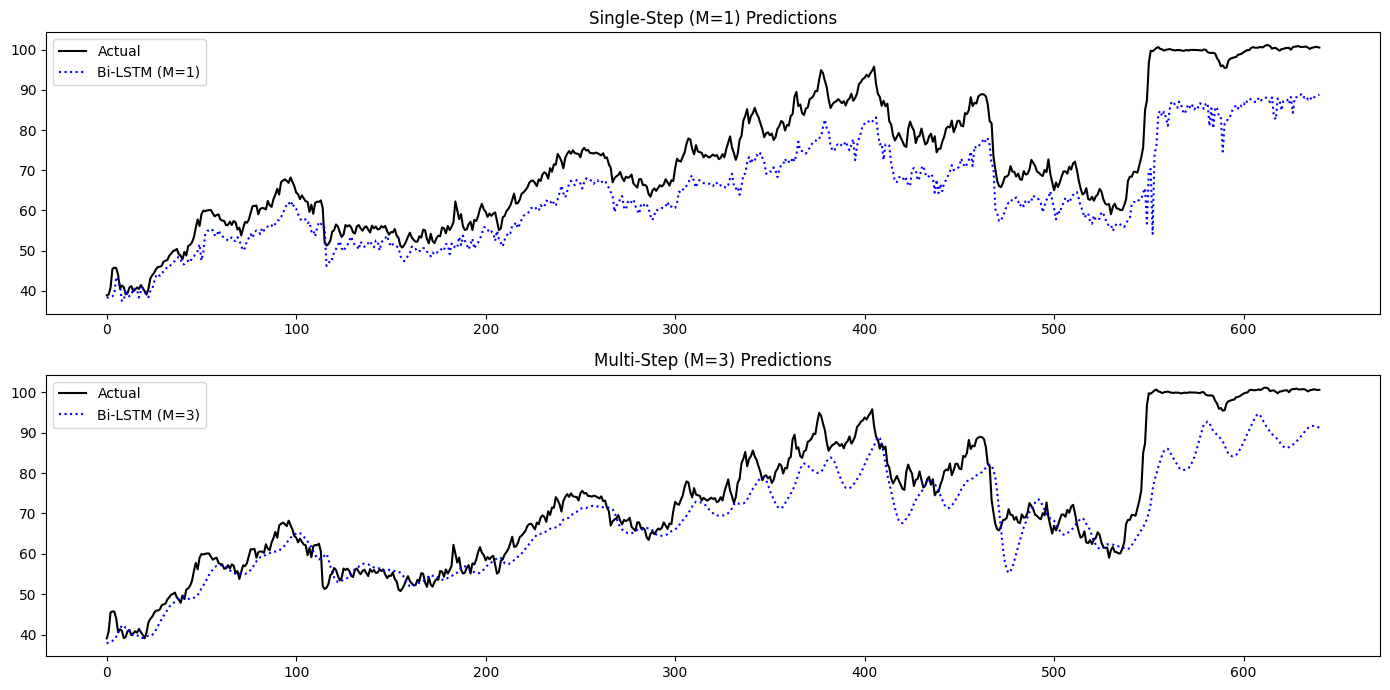

In [ ]:
plt.figure(figsize=(14, 7))

# M=1
plt.subplot(2, 1, 1)
plt.plot(y_test_close_m1, label='Actual', color='black')
plt.plot(bi_lstm_predictions_m1, label='Bi-LSTM (M=1)', linestyle='dotted', color='blue')
plt.title('Single-Step (M=1) Predictions')
plt.legend()

# M=3
plt.subplot(2, 1, 2)
plt.plot(y_test_close.flatten(), label='Actual', color='black')
plt.plot(bi_lstm_predictions.flatten(), label='Bi-LSTM (M=3)', linestyle='dotted', color='blue')
plt.title('Multi-Step (M=3) Predictions')
plt.legend()

plt.tight_layout()
plt.show()


Best among the two: Single Step and Multi step

In [ ]:
# Single-Step (M=1) Metrics
m1_results = {
    "RNN": {"MSE": rnn_mse_m1, "MAE": rnn_mae_m1, "R²": rnn_r2_m1},
    "GRU": {"MSE": gru_mse_m1, "MAE": gru_mae_m1, "R²": gru_r2_m1},
    "LSTM": {"MSE": lstm_mse_m1, "MAE": lstm_mae_m1, "R²": lstm_r2_m1},
    "Bi-LSTM": {"MSE": bi_lstm_mse_m1, "MAE": bi_lstm_mae_m1, "R²": bi_lstm_r2_m1},
}

# Multi-Step (M=3) Metrics
m3_results = {
    "RNN": {"MSE": rnn_mse, "MAE": rnn_mae, "R²": rnn_r2},
    "GRU": {"MSE": gru_mse, "MAE": gru_mae, "R²": gru_r2},
    "LSTM": {"MSE": lstm_mse, "MAE": lstm_mae, "R²": lstm_r2},
    "Bi-LSTM": {"MSE": bi_lstm_mse, "MAE": bi_lstm_mae, "R²": bi_lstm_r2},
}

# Comparing the Results
def compare_single_multi_step(m1_results, m3_results):
    print("Performance Comparison Between M=1 and M=3:")
    for model in m1_results.keys():
        print(f"{model}:")
        print(f"  M=1 -> MSE: {m1_results[model]['MSE']:.4f}, MAE: {m1_results[model]['MAE']:.4f}, R²: {m1_results[model]['R²']:.4f}")
        print(f"  M=3 -> MSE: {m3_results[model]['MSE']:.4f}, MAE: {m3_results[model]['MAE']:.4f}, R²: {m3_results[model]['R²']:.4f}")
        print()

compare_single_multi_step(m1_results, m3_results)


Performance Comparison Between M=1 and M=3:
RNN:
  M=1 -> MSE: 14.4499, MAE: 2.8877, R²: 0.9459
  M=3 -> MSE: 12.8542, MAE: 2.5922, R²: 0.9518

GRU:
  M=1 -> MSE: 3.8167, MAE: 1.5121, R²: 0.9857
  M=3 -> MSE: 12.9890, MAE: 2.6167, R²: 0.9513

LSTM:
  M=1 -> MSE: 15.5514, MAE: 3.0516, R²: 0.9417
  M=3 -> MSE: 19.3611, MAE: 3.2114, R²: 0.9273

Bi-LSTM:
  M=1 -> MSE: 84.7298, MAE: 8.0102, R²: 0.6826
  M=3 -> MSE: 51.1581, MAE: 5.3079, R²: 0.8080



In [ ]:
def decide_best_step(m1_results, m3_results):

    best_steps = {}
    m1_count = 0
    m3_count = 0

    for model in m1_results:
        if m1_results[model]["MSE"] < m3_results[model]["MSE"]:
            best_steps[model] = "M=1"
            m1_count += 1
        else:
            best_steps[model] = "M=3"
            m3_count += 1

    overall_best_step = "M=1" if m1_count > m3_count else "M=3"

    print("Best Step for Each Model:")
    for model, step in best_steps.items():
        print(f"{model}: {step}")

    print(f"\nOverall Best Step: {overall_best_step}")
    return overall_best_step

best_among_two = decide_best_step(m1_results, m3_results)


Best Step for Each Model:
RNN: M=3
GRU: M=1
LSTM: M=1
Bi-LSTM: M=3

Overall Best Step: M=3


In [ ]:
print(best_among_two)

M=3


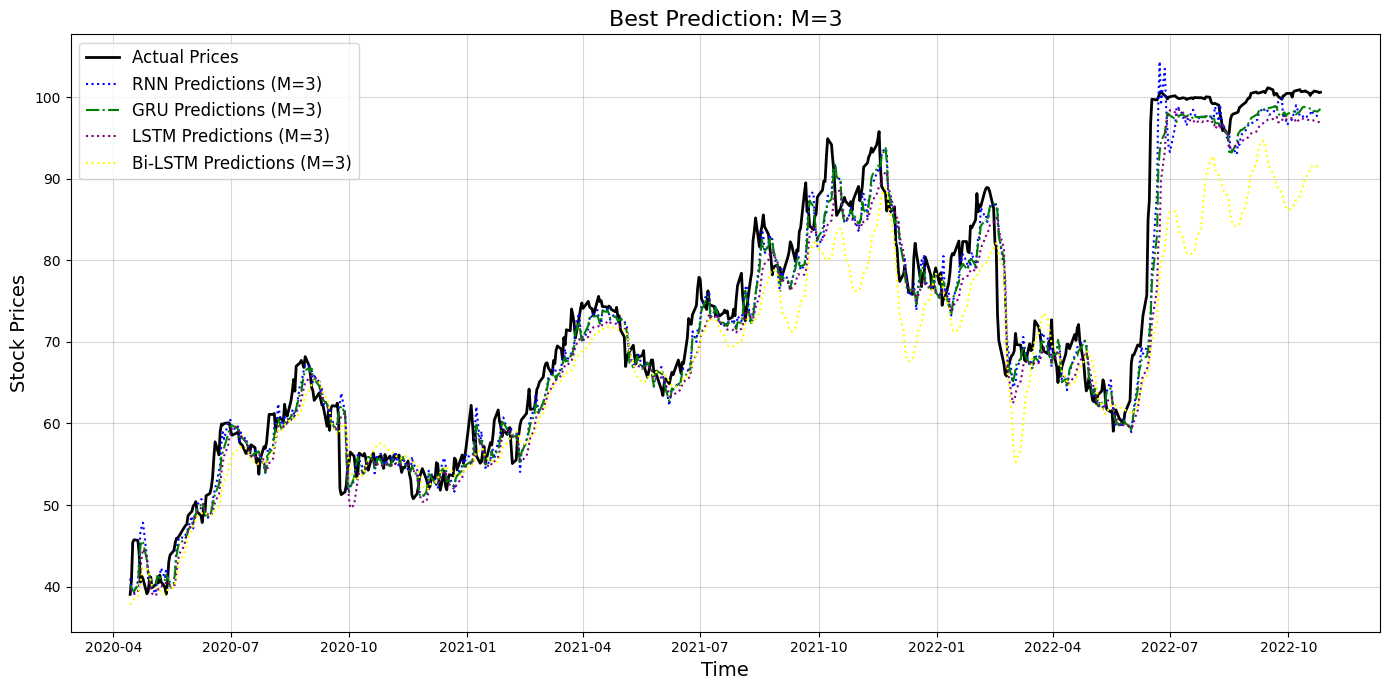

In [ ]:
# Plotting Best Predictions (M=1 or M=3 based on metrics)
best_step = best_among_two

plt.figure(figsize=(14, 7))
if best_step == "M=1":
    plt.plot(aligned_dates_m1, y_test_close_m1, label='Actual Prices', color='black', linewidth=2)
    plt.plot(aligned_dates_m1, rnn_predictions_m1, label='RNN Predictions (M=1)', linestyle='dotted', color='blue')
    plt.plot(aligned_dates_m1, gru_predictions_m1, label='GRU Predictions (M=1)', linestyle='dashdot', color='green')
    plt.plot(aligned_dates_m1, lstm_predictions_m1, label='LSTM Predictions (M=1)', linestyle='dotted', color='purple')
    plt.plot(aligned_dates_m1, bi_lstm_predictions_m1, label='Bi-LSTM Predictions (M=1)', linestyle='dotted', color='yellow')
else:
    plt.plot(aligned_dates, y_test_close.flatten(), label='Actual Prices', color='black', linewidth=2)
    plt.plot(aligned_dates, rnn_predictions.flatten(), label='RNN Predictions (M=3)', linestyle='dotted', color='blue')
    plt.plot(aligned_dates, gru_predictions.flatten(), label='GRU Predictions (M=3)', linestyle='dashdot', color='green')
    plt.plot(aligned_dates, lstm_predictions.flatten(), label='LSTM Predictions (M=3)', linestyle='dotted', color='purple')
    plt.plot(aligned_dates, bi_lstm_predictions.flatten(), label='Bi-LSTM Predictions (M=3)', linestyle='dotted', color='yellow')

plt.title(f'Best Prediction: {best_step}', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Stock Prices', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
